## DNN Training, Tuning and Predictions:

In [1]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

print("Tensorflow Version: ", tf.__version__)

Tensorflow Version:  2.0.0-dev20191002


## Creating and Plotting Time-Series:

In [2]:
def plot_series(series, time, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    
    
def trend(time, slope=0):
    return time * slope


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, which could be changed!"""
    return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1/np.exp(3 * season_time))
    
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time+phase) % period) / period
    
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4*365+1, dtype='float32')
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Updated the noise
series += noise(time, noise_level, seed=42)

## Train / Validation Sets:

In [3]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

## Creating Windowed Dataset:

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    
    dataset = tf.data.Dataset.from_tensor_slices(series) # creates the dataset from data series
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

## Creating DNN Model with Keras:

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# build the model 
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

# compiling the model 
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

# fit the model 
model.fit(dataset, epochs=100, verbose=0)

## Making Forecasts:

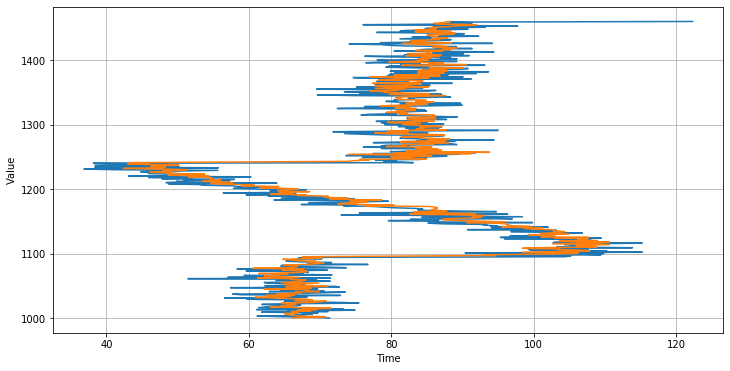

In [8]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]

results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(12,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)